In [83]:
# Code:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/acgan/acgan.py

In [1]:
# Imports
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# Models
from torchvision.models import vgg19
from sys import path
path.append("../utils")
from models import LeNet5

In [3]:
# Configs

cuda = True

n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
latent_dim=100
n_classes=10
img_size=28
channels=1
sample_interval=500

d_real_loss_coeff = 0.6
d_fake_loss_coeff = 0.4

adv_loss_coeff = 1
aux_loss_coeff = 1
tar_loss_coeff = .05

tar_loss_default = 22.2  # This is equal to the max possible tar_loss value

# target classifier conditional constants
adv_loss_threshold = 0.9
aux_loss_threshold = 1.48

lenet5_state_path = "../utils/models/trained_lenet5.pkl"


In [4]:
# Load functions for fixed target classifier

def load_pytorch_model():
    # Load model from torchvision.models (NOTE: VVG19 IS NOT FOR MNIST, DON'T USE)
    model = vgg19(pretrained=True)
    model.eval()
    if cuda:
        model.cuda()
    
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = False

    return model

def load_LeNet5():
    net = LeNet5()
    if cuda:
        net.cuda()
    
    # remove map location = cpu if using cuda
    net.load_state_dict(torch.load(lenet5_state_path, map_location=torch.device('cpu')))
    
    # set model to eval mode so nothing is changed
    net.eval()
    
    return net
    

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [6]:
# Models

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 2#img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


In [7]:
# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()
target_classifier_loss = nn.CrossEntropyLoss() # negate target classifier output when passing to this loss function

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Load target classifier

target_classifier = load_LeNet5()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()
    target_classifier = target_classifier.cuda()
    target_classifier_loss = target_classifier_loss.cuda()

In [8]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [9]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "../images/%d.png" % batches_done, nrow=n_row, normalize=True)
    

In [10]:
'''
def shouldCalculateTargetLoss(validity, pred_label, label):
    # Only works if batch size is 1, so just uses the first value
    return (validity > threshold_valid and  # validity is above threshold
        pred_label[label] == np.amax(pred_label) and  # classification is correct
        pred_label[label] > threshold_classification)  # classification confidence is above threshold

def get_target_loss(validity, pred_labels, label, target_classification):
    # Apply conditional loss to each output individually
    for i in range(target_classification.size(0)):
        if shouldCalculateTargetLoss(validity[i], pred_labels[i], label[i]):
            target_classification[i] *= -1
            
            
    loss = target_classifier_loss(target_classification, gen_labels)
    
    print("Count of loss including target loss:", torch.sum(loss_mult))
    
    return loss * loss_mult
'''


def get_target_loss(adv_loss, aux_loss, target_classification, true_classification):
    #print(target_classification[0])
    if (adv_loss < adv_loss_threshold and aux_loss < aux_loss_threshold):
        return target_classifier_loss(target_classification * -1, true_classification)
    return Variable(FloatTensor([tar_loss_default]))

def test_attack(size):
    z = Variable(FloatTensor(np.random.normal(0, 1, (size, latent_dim))))
    gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, size)))
    imgs = generator(z, gen_labels)
    validity, pred_label = discriminator(imgs)
    

# TEMPORARY SECTION: testing target classifier output

z = Variable(FloatTensor(np.random.normal(0, 1, (1, latent_dim))))
gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, 1)))
imgs = generator(z, gen_labels)
validity, pred_label = discriminator(imgs)

#print(validity)


#bceloss_test = nn.BCELoss()
celoss_test = nn.CrossEntropyLoss()

inp = Variable(FloatTensor([[10,10,10,10,10,10,10,10,10,-10]]))
true = Variable(LongTensor([9]))

print(celoss_test(inp, true))

#print(bceloss_test(Variable(FloatTensor([[0.65]])), Variable(FloatTensor([[1]]))))

In [11]:
# Training
import csv
f = open('../models/Run2_log.csv', 'a')
log_writer = csv.writer(f, delimiter=',')
log_writer.writerow(['Epoch', 'Batch', 'DLoss', 'DAcc', 'TarAcc', 'AdvLoss', 'AuxLoss', 'TarLoss', 'GLoss'])
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        
        batch_size = imgs.shape[0]
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        target_classifier_pred_label = target_classifier(gen_imgs)
        
        t_acc = np.mean(np.argmax(target_classifier_pred_label.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy())
        
        adv_loss = adv_loss_coeff * adversarial_loss(validity, valid)
        aux_loss = aux_loss_coeff * auxiliary_loss(pred_label, gen_labels)
        tar_loss = tar_loss_coeff * get_target_loss(adv_loss, aux_loss, target_classifier_pred_label, gen_labels)
        g_loss = adv_loss + aux_loss + tar_loss
        
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = d_real_loss_coeff * d_real_loss + d_fake_loss_coeff * d_fake_loss

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()
        
        log_writer.writerow([epoch, i, d_loss.item(), 100*d_acc, 100*t_acc, adv_loss.item(), aux_loss.item(), tar_loss.item(), g_loss.item()])
        
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
            # Saves weights
            torch.save(generator.state_dict(), "../models/Success2_G")
            torch.save(discriminator.state_dict(), "../models/Success2_D")
            print(
                "=====================\nEpoch %d/%d, Batch %d/%d\nD loss: %f, acc: %d%% // tar acc: %d%% // adv loss: %f, aux loss: %f, tar loss: %f"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, 100 * t_acc, adv_loss.item(), aux_loss.item(), tar_loss.item())
            )


/home/achyut/Projects/AdversarialRobustness/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0/200, Batch 0/938
D loss: 1.496471, acc: 10% // tar acc: 6% // adv loss: 0.680685, aux loss: 2.302219, tar loss: 1.110000
Epoch 0/200, Batch 500/938
D loss: 1.244165, acc: 60% // tar acc: 32% // adv loss: 0.522499, aux loss: 2.058553, tar loss: 1.110000
Epoch 1/200, Batch 62/938
D loss: 1.076492, acc: 89% // tar acc: 65% // adv loss: 0.716126, aux loss: 1.581210, tar loss: 1.110000
Epoch 1/200, Batch 562/938
D loss: 1.086960, acc: 89% // tar acc: 82% // adv loss: 0.625577, aux loss: 1.530647, tar loss: 1.110000
Epoch 2/200, Batch 124/938
D loss: 1.076780, acc: 95% // tar acc: 79% // adv loss: 0.657504, aux loss: 1.520543, tar loss: 1.110000
Epoch 2/200, Batch 624/938
D loss: 1.050300, acc: 94% // tar acc: 79% // adv loss: 0.788152, aux loss: 1.482747, tar loss: 1.110000
Epoch 3/200, Batch 186/938
D loss: 1.049540, acc: 93% // tar acc: 89% // adv loss: 0.694938, aux loss: 1.511545, tar loss: 1.110000
Epoch 3/200, Batch 686/938
D loss: 1.107228, acc: 95% // tar acc: 81% // adv los

Epoch 28/200, Batch 236/938
D loss: 1.058966, acc: 96% // tar acc: 92% // adv loss: 0.555245, aux loss: 1.484763, tar loss: 1.110000
Epoch 28/200, Batch 736/938
D loss: 1.094902, acc: 97% // tar acc: 90% // adv loss: 0.513282, aux loss: 1.475943, tar loss: 0.666770
Epoch 29/200, Batch 298/938
D loss: 1.100030, acc: 97% // tar acc: 98% // adv loss: 0.472176, aux loss: 1.474909, tar loss: 0.716309
Epoch 29/200, Batch 798/938
D loss: 1.052245, acc: 98% // tar acc: 95% // adv loss: 0.767529, aux loss: 1.467054, tar loss: 0.667246
Epoch 30/200, Batch 360/938
D loss: 1.070722, acc: 95% // tar acc: 90% // adv loss: 0.605066, aux loss: 1.479037, tar loss: 0.675978
Epoch 30/200, Batch 860/938
D loss: 1.113433, acc: 96% // tar acc: 93% // adv loss: 0.701868, aux loss: 1.476196, tar loss: 0.720308
Epoch 31/200, Batch 422/938
D loss: 1.088548, acc: 98% // tar acc: 93% // adv loss: 0.700036, aux loss: 1.471754, tar loss: 0.674842
Epoch 31/200, Batch 922/938
D loss: 1.111251, acc: 97% // tar acc: 93

Epoch 56/200, Batch 472/938
D loss: 1.097376, acc: 97% // tar acc: 98% // adv loss: 0.586164, aux loss: 1.470191, tar loss: 0.727943
Epoch 57/200, Batch 34/938
D loss: 1.072906, acc: 100% // tar acc: 98% // adv loss: 0.343300, aux loss: 1.470239, tar loss: 0.761386
Epoch 57/200, Batch 534/938
D loss: 1.116461, acc: 99% // tar acc: 98% // adv loss: 0.456984, aux loss: 1.475827, tar loss: 0.732722
Epoch 58/200, Batch 96/938
D loss: 1.039398, acc: 99% // tar acc: 98% // adv loss: 0.580406, aux loss: 1.461217, tar loss: 0.764191
Epoch 58/200, Batch 596/938
D loss: 1.137089, acc: 98% // tar acc: 96% // adv loss: 0.393357, aux loss: 1.508871, tar loss: 1.110000
Epoch 59/200, Batch 158/938
D loss: 1.034417, acc: 97% // tar acc: 96% // adv loss: 0.445418, aux loss: 1.477736, tar loss: 0.726244
Epoch 59/200, Batch 658/938
D loss: 1.070597, acc: 98% // tar acc: 96% // adv loss: 0.538131, aux loss: 1.477825, tar loss: 0.732716
Epoch 60/200, Batch 220/938
D loss: 1.083262, acc: 98% // tar acc: 100

Epoch 84/200, Batch 708/938
D loss: 1.036918, acc: 99% // tar acc: 100% // adv loss: 0.490782, aux loss: 1.461796, tar loss: 0.725036
Epoch 85/200, Batch 270/938
D loss: 1.087543, acc: 100% // tar acc: 98% // adv loss: 0.574082, aux loss: 1.465254, tar loss: 0.750062
Epoch 85/200, Batch 770/938
D loss: 1.069425, acc: 98% // tar acc: 96% // adv loss: 0.541370, aux loss: 1.472052, tar loss: 0.733162
Epoch 86/200, Batch 332/938
D loss: 1.028328, acc: 94% // tar acc: 100% // adv loss: 0.552051, aux loss: 1.461738, tar loss: 0.767940
Epoch 86/200, Batch 832/938
D loss: 1.102319, acc: 98% // tar acc: 98% // adv loss: 0.574909, aux loss: 1.467092, tar loss: 0.748562
Epoch 87/200, Batch 394/938
D loss: 1.122140, acc: 97% // tar acc: 95% // adv loss: 0.492706, aux loss: 1.489296, tar loss: 1.110000
Epoch 87/200, Batch 894/938
D loss: 1.027699, acc: 99% // tar acc: 100% // adv loss: 0.380148, aux loss: 1.462241, tar loss: 0.716818
Epoch 88/200, Batch 456/938
D loss: 1.075253, acc: 98% // tar acc

Epoch 113/200, Batch 6/938
D loss: 1.103758, acc: 96% // tar acc: 98% // adv loss: 0.652833, aux loss: 1.479757, tar loss: 0.724463
Epoch 113/200, Batch 506/938
D loss: 1.054078, acc: 99% // tar acc: 93% // adv loss: 0.568651, aux loss: 1.475664, tar loss: 0.701824
Epoch 114/200, Batch 68/938
D loss: 1.028264, acc: 100% // tar acc: 95% // adv loss: 0.541973, aux loss: 1.468399, tar loss: 0.735935
Epoch 114/200, Batch 568/938
D loss: 1.077362, acc: 98% // tar acc: 92% // adv loss: 0.530133, aux loss: 1.461492, tar loss: 0.731546
Epoch 115/200, Batch 130/938
D loss: 1.098559, acc: 98% // tar acc: 93% // adv loss: 0.604282, aux loss: 1.461169, tar loss: 0.768441
Epoch 115/200, Batch 630/938
D loss: 1.020148, acc: 97% // tar acc: 93% // adv loss: 0.599339, aux loss: 1.478329, tar loss: 0.706356
Epoch 116/200, Batch 192/938
D loss: 1.064544, acc: 99% // tar acc: 98% // adv loss: 0.403904, aux loss: 1.463603, tar loss: 0.710789
Epoch 116/200, Batch 692/938
D loss: 1.068958, acc: 96% // tar a

Epoch 141/200, Batch 242/938
D loss: 1.041348, acc: 100% // tar acc: 96% // adv loss: 0.601877, aux loss: 1.461156, tar loss: 0.728066
Epoch 141/200, Batch 742/938
D loss: 0.981212, acc: 98% // tar acc: 98% // adv loss: 0.453854, aux loss: 1.476413, tar loss: 0.740815
Epoch 142/200, Batch 304/938
D loss: 1.031346, acc: 99% // tar acc: 96% // adv loss: 0.597584, aux loss: 1.461367, tar loss: 0.737435
Epoch 142/200, Batch 804/938
D loss: 1.046610, acc: 96% // tar acc: 96% // adv loss: 0.464298, aux loss: 1.466286, tar loss: 0.727960
Epoch 143/200, Batch 366/938
D loss: 1.082028, acc: 99% // tar acc: 96% // adv loss: 0.458199, aux loss: 1.461507, tar loss: 0.752208
Epoch 143/200, Batch 866/938
D loss: 1.009441, acc: 100% // tar acc: 98% // adv loss: 0.515554, aux loss: 1.462531, tar loss: 0.728422
Epoch 144/200, Batch 428/938
D loss: 1.071695, acc: 100% // tar acc: 93% // adv loss: 0.352840, aux loss: 1.462008, tar loss: 0.745982
Epoch 144/200, Batch 928/938
D loss: 1.089451, acc: 98% // 

Epoch 169/200, Batch 478/938
D loss: 1.097578, acc: 96% // tar acc: 95% // adv loss: 0.630628, aux loss: 1.490201, tar loss: 1.110000
Epoch 170/200, Batch 40/938
D loss: 1.085714, acc: 100% // tar acc: 96% // adv loss: 0.467572, aux loss: 1.462662, tar loss: 0.741092
Epoch 170/200, Batch 540/938
D loss: 1.081771, acc: 98% // tar acc: 96% // adv loss: 0.778774, aux loss: 1.476852, tar loss: 0.722795
Epoch 171/200, Batch 102/938
D loss: 1.049416, acc: 98% // tar acc: 90% // adv loss: 0.572177, aux loss: 1.476108, tar loss: 0.721377
Epoch 171/200, Batch 602/938
D loss: 1.066619, acc: 96% // tar acc: 98% // adv loss: 0.512080, aux loss: 1.471441, tar loss: 0.736313
Epoch 172/200, Batch 164/938
D loss: 1.006714, acc: 98% // tar acc: 100% // adv loss: 0.579929, aux loss: 1.461933, tar loss: 0.765095
Epoch 172/200, Batch 664/938
D loss: 1.055970, acc: 99% // tar acc: 95% // adv loss: 0.352413, aux loss: 1.461166, tar loss: 0.732516
Epoch 173/200, Batch 226/938
D loss: 1.085546, acc: 97% // ta

Epoch 197/200, Batch 714/938
D loss: 1.090556, acc: 100% // tar acc: 96% // adv loss: 0.521840, aux loss: 1.462583, tar loss: 0.715464
Epoch 198/200, Batch 276/938
D loss: 1.110210, acc: 99% // tar acc: 95% // adv loss: 0.413220, aux loss: 1.475931, tar loss: 0.735903
Epoch 198/200, Batch 776/938
D loss: 1.025543, acc: 97% // tar acc: 95% // adv loss: 0.633249, aux loss: 1.491300, tar loss: 1.110000
Epoch 199/200, Batch 338/938
D loss: 1.039352, acc: 99% // tar acc: 100% // adv loss: 0.474189, aux loss: 1.461372, tar loss: 0.739939
Epoch 199/200, Batch 838/938
D loss: 1.096465, acc: 96% // tar acc: 96% // adv loss: 0.363089, aux loss: 1.461183, tar loss: 0.750407


In [12]:
# Saves weights
torch.save(generator.state_dict(), "../models/Success2_G")
torch.save(discriminator.state_dict(), "../models/Success2_D")

In [40]:
# Testing
batch_size = 1000
z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

# Generate a batch of images
gen_imgs = generator(z, gen_labels)

tensor(9, device='cuda:0')


Text(0.5, 1.0, 'Gen Label: 9; LeNet Label: 3')

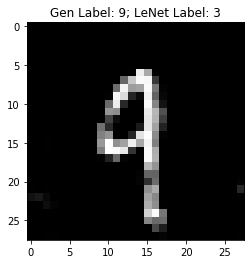

In [45]:
# Plots a sample
import matplotlib.pyplot as plt
sample_idx = 28
print(gen_labels[sample_idx])
plt.imshow(gen_imgs[sample_idx][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
plt.title("Gen Label: " + str(gen_labels.cpu().detach().numpy()[sample_idx]) + "; LeNet Label: " + str(np.argmax(pred_labels.data.cpu().numpy()[sample_idx])))

In [43]:
# Finds target classification for sample
pred_labels = target_classifier(gen_imgs)
np.argmax(pred_labels.data.cpu().numpy()[sample_idx])
#pred_labels.data.cpu().numpy()[sample_idx]

5

In [44]:
# Finds indexes that have adversarial examples
t_acc = np.argmax(pred_labels.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy()
np.where(t_acc == False)

(array([ 28, 120, 163, 301, 308, 338, 357, 381, 411, 473, 481, 630, 671,
        733, 763, 859, 939, 950, 952, 954, 961, 970]),)

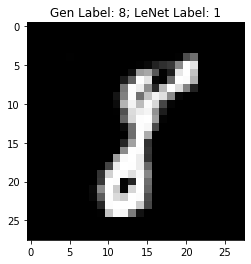

In [46]:
gen = gen_imgs.cpu().detach().numpy()
preds = pred_labels.data.cpu().numpy()
true = gen_labels.data.cpu().numpy()
for i in range(len(true)):
    if np.argmax(preds[i]) != true[i]:
        plt.title("Gen Label: " + str(true[i]) + "; LeNet Label: " + str(np.argmax(preds[i])))
        plt.imshow(gen[i][0], cmap='gray')
        plt.savefig("../images/SecondRun/AdversarialExamples/" + str(1000+i) + ".png")
        
#for i in range(len(true)):
#    plt.title("Gen Label: " + str(true[i]) + "; LeNet Label: " + str(np.argmax(preds[i])))
#    plt.imshow(gen[i][0], cmap='gray')
#    plt.savefig("../images/SecondRun/AllSamples/" + str(i) + ".png")

In [39]:
# Extra saving
torch.save(gen_imgs, "../models/Success2_GenSample")
torch.save(gen_labels, "../models/Success2_GenLabels")
torch.save(pred_labels, "../models/Success2_LeNetLabels")